In [1]:
# # Before proceeding run this cell (but if you have already install then ignore)
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install wordcloud
# !pip install nltk

# Load Libraries

In [4]:
import tensorflow as tf

# dl packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [5]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [6]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [7]:
train_data.shape

(16000, 3)

In [8]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [9]:
train_data.duplicated().sum()

np.int64(1)

# EDA

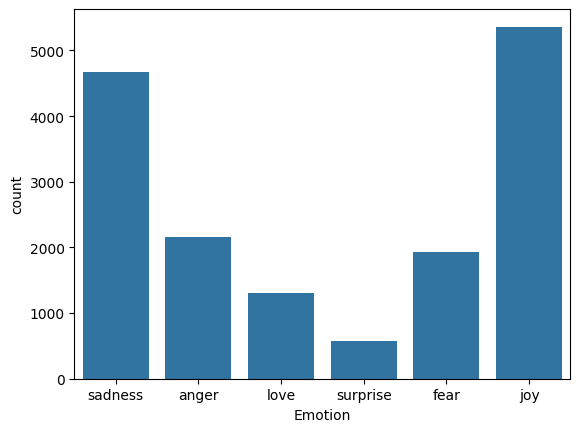

In [10]:
sns.countplot(x = train_data['Emotion'])
plt.show()

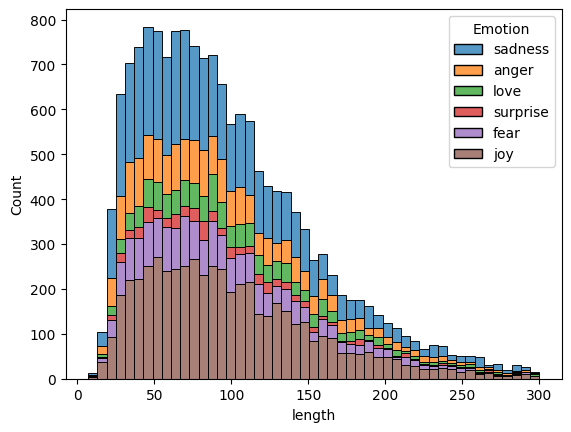

In [11]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

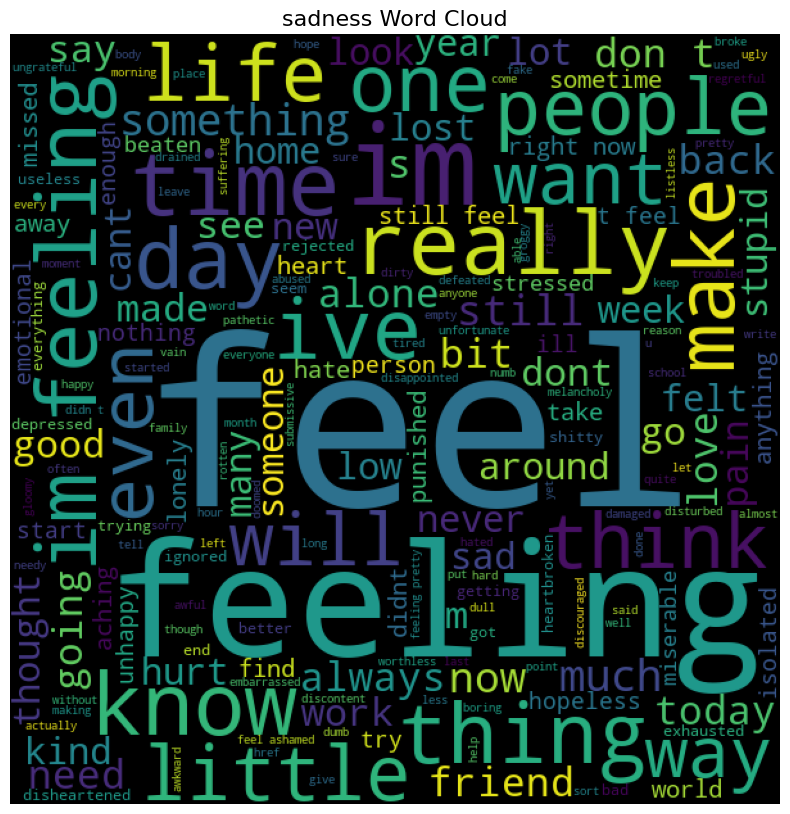

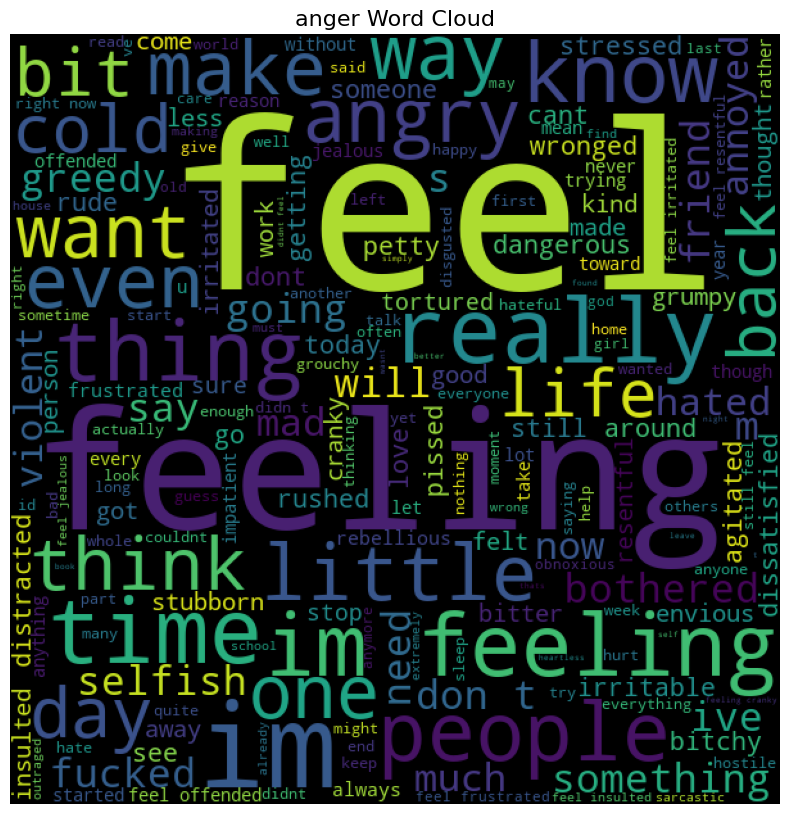

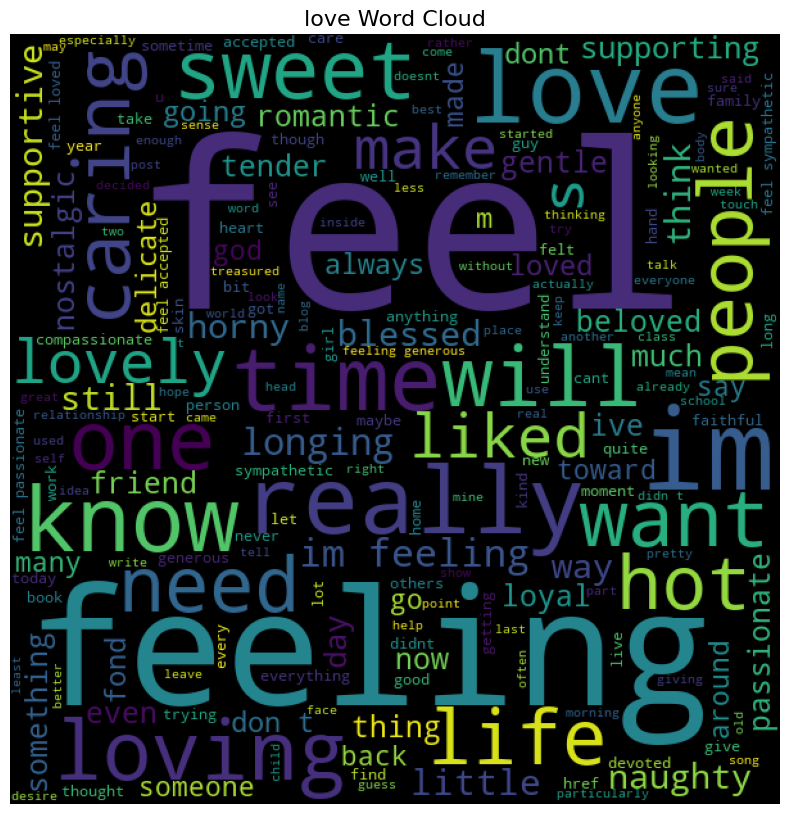

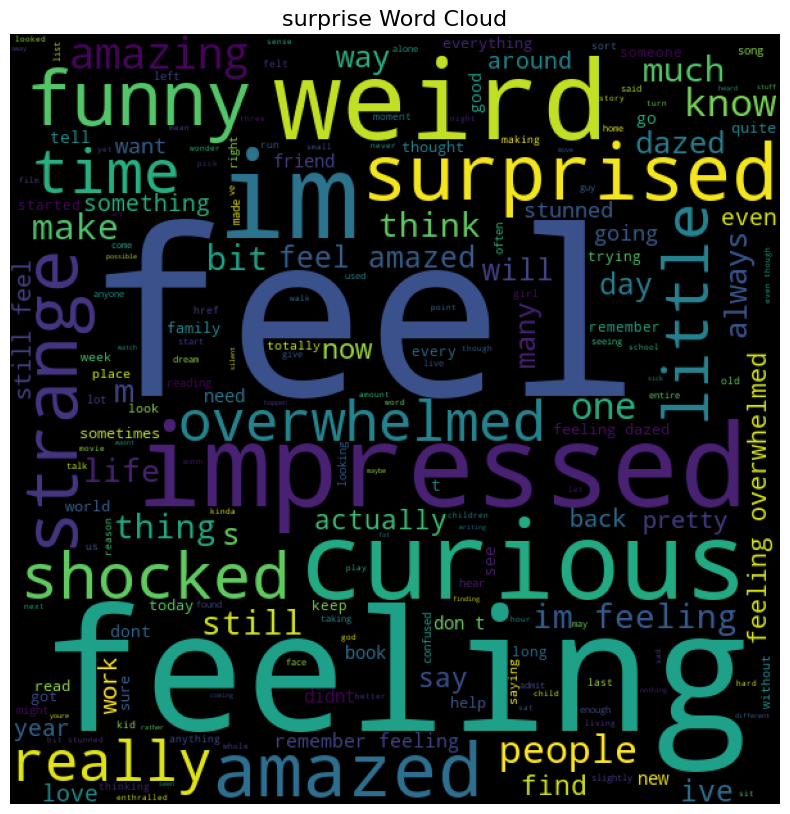

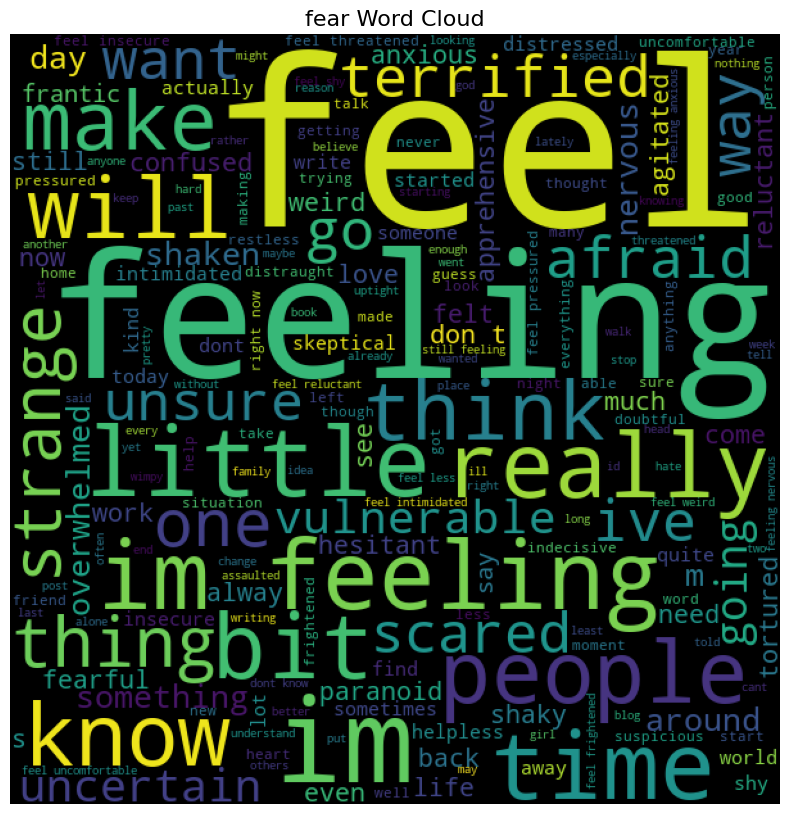

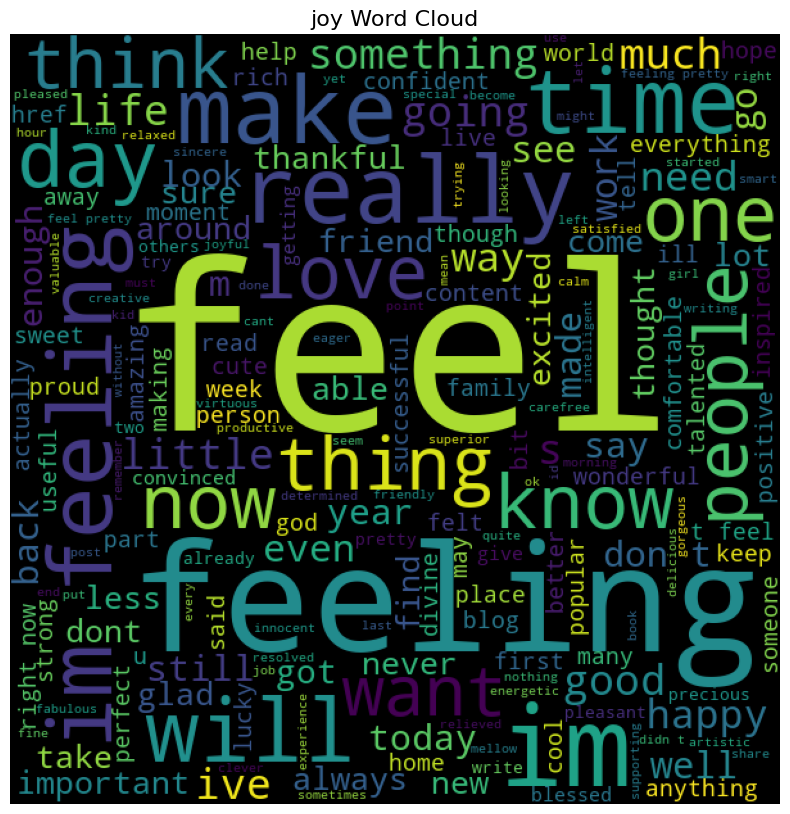

In [12]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [13]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [14]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Applying Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [16]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [17]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [18]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [20]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [21]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.655
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


===== Logistic Regression =====

Accuracy using TF-IDF: 0.829375
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
       

In [22]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [23]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [24]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [25]:
import sklearn
print(sklearn.__version__) # use this version in pycharm

1.6.1


# Applying Deep learning Using LSTM

# Text Cleaning, Ecoding, and Padding

In [29]:
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stop_words]
        text = " ".join(text)
        corpus.append(text)

    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    pad = pad_sequences(sequences=sequences, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Model Building and Training

In [30]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

d:\DLP\LSTM-DL-ML\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 411ms/step - accuracy: 0.3358 - loss: 1.6364
Epoch 2/10


d:\DLP\LSTM-DL-ML\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 429ms/step - accuracy: 0.6785 - loss: 0.9362
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 154s 618ms/step - accuracy: 0.8832 - loss: 0.3805
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 570ms/step - accuracy: 0.9339 - loss: 0.2062
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 712ms/step - accuracy: 0.9569 - loss: 0.1327
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 717ms/step - accuracy: 0.9689 - loss: 0.0953
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accuracy: 0.9729 - loss: 0.0804
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 498ms/step - accuracy: 0.9776 - loss: 0.0667
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 192s 769ms/step - accuracy: 0.9816 - loss: 0.0517
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 197s 787ms/step - accuracy: 0.9830 - loss: 0.0502


# Predictive System

In [32]:
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text cleaning function
def sentence_cleaning(sentence, tokenizer, max_len):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = " ".join(text)
    sequence = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(sequence, maxlen=max_len, padding='pre')
    return pad

# Create a tokenizer and fit it to your training data
tokenizer = Tokenizer(num_words=11000)
# tokenizer.fit_on_texts(your_training_data)

max_len = 300
sentences = [
    # your sentences here
]

for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence, tokenizer, max_len)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba = np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Save the model and files

In [33]:

model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

In [34]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

3.10.0
2.19.0
